In [23]:
# imports
import warnings
warnings.simplefilter("ignore", UserWarning)

import os
import gdown
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

from torchvision.utils import save_image, make_grid
from torchvision import transforms
from torchvision import models
from torchinfo import summary

In [24]:
# utils functions ans model implementation
def calc_mean_std(features):
    """
    :param features: shape of features -> [batch_size, c, h, w]
    :return: features_mean, feature_s: shape of mean/std ->[batch_size, c, 1, 1]
    """

    batch_size, c = features.size()[:2]
    features_mean = features.reshape(batch_size, c, -1).mean(dim=2).reshape(batch_size, c, 1, 1)
    features_std = features.reshape(batch_size, c, -1).std(dim=2).reshape(batch_size, c, 1, 1) + 1e-6
    return features_mean, features_std


def adain(content_features, style_features):
    """
    Adaptive Instance Normalization
    :param content_features: shape -> [batch_size, c, h, w]
    :param style_features: shape -> [batch_size, c, h, w]
    :return: normalized_features shape -> [batch_size, c, h, w]
    """
    content_mean, content_std = calc_mean_std(content_features)
    style_mean, style_std = calc_mean_std(style_features)
    normalized_features = style_std * (content_features - content_mean) / content_std + style_mean
    return normalized_features



In [25]:
class VGGEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features
        self.slice1 = vgg[: 2]
        self.slice2 = vgg[2: 7]
        self.slice3 = vgg[7: 12]
        self.slice4 = vgg[12: 21]
        for p in self.parameters():
            p.requires_grad = False

    def forward(self, images, output_last_feature=False):

        h1 = self.slice1(images)
        h2 = self.slice2(h1)
        h3 = self.slice3(h2)
        h4 = self.slice4(h3)
        if output_last_feature:
            return h4
        else:
            return h1, h2, h3, h4


class RC(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, pad_size=1, activated=True):
        super().__init__()
        self.pad = nn.ReflectionPad2d((pad_size, pad_size, pad_size, pad_size))
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activated = activated

    def forward(self, x):
        h = self.pad(x)
        h = self.conv(h)
        if self.activated:
            return F.relu(h)
        else:
            return h


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.rc1 = RC(512, 256, 3, 1)
        self.rc2 = RC(256, 256, 3, 1)
        self.rc3 = RC(256, 256, 3, 1)
        self.rc4 = RC(256, 256, 3, 1)
        self.rc5 = RC(256, 128, 3, 1)
        self.rc6 = RC(128, 128, 3, 1)
        self.rc7 = RC(128, 64, 3, 1)
        self.rc8 = RC(64, 64, 3, 1)
        self.rc9 = RC(64, 3, 3, 1, False)

    def forward(self, features):
        h = self.rc1(features)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc2(h)
        h = self.rc3(h)
        h = self.rc4(h)
        h = self.rc5(h)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc6(h)
        h = self.rc7(h)
        h = F.interpolate(h, scale_factor=2)
        h = self.rc8(h)
        h = self.rc9(h)
        return h


In [26]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg_encoder = VGGEncoder()
        self.decoder = Decoder()

    def generate(self, content_images, style_images, alpha=1.0):
        self.vgg_encode = self.vgg_encoder
        content_features = self.vgg_encoder(content_images, output_last_feature=True)
        style_features = self.vgg_encoder(style_images, output_last_feature=True)
        t = adain(content_features, style_features)
        t = alpha * t + (1 - alpha) * content_features
        out = self.decoder(t)
        return out

    @staticmethod
    def calc_content_loss(out_features, t):
        return F.mse_loss(out_features, t)

    @staticmethod
    def calc_style_loss(content_middle_features, style_middle_features):
        loss = 0
        for c, s in zip(content_middle_features, style_middle_features):
            c_mean, c_std = calc_mean_std(c)
            s_mean, s_std = calc_mean_std(s)
            loss += F.mse_loss(c_mean, s_mean) + F.mse_loss(c_std, s_std)
        return loss

    def forward(self, content_images, style_images, alpha=1.0, lam=10):
        content_features = self.vgg_encoder(content_images, output_last_feature=True)
        style_features = self.vgg_encoder(style_images, output_last_feature=True)
        t = adain(content_features, style_features)
        t = alpha * t + (1 - alpha) * content_features
        out = self.decoder(t)

        output_features = self.vgg_encoder(out, output_last_feature=True)
        output_middle_features = self.vgg_encoder(out, output_last_feature=False)
        style_middle_features = self.vgg_encoder(style_images, output_last_feature=False)

        loss_c = self.calc_content_loss(output_features, t)
        loss_s = self.calc_style_loss(output_middle_features, style_middle_features)
        loss = loss_c + lam * loss_s
        return loss

In [27]:
# dataset

transform = transforms.Compose([
    transforms.Resize(size=512),
    transforms.RandomCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


def denorm(tensor, device):
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(-1, 1, 1).to(device)
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(-1, 1, 1).to(device)
    res = torch.clamp(tensor * std + mean, 0, 1)
    return res


class ContentStyleDataset(Dataset):
    def __init__(self, content_dir, style_dir, num_range, transform=transform):
        content_images = glob.glob(os.path.join(content_dir, "*.jpg"))      
        style_images = glob.glob(os.path.join(style_dir, "*.jpg"))
        
        self.images_pairs = list(zip(content_images, style_images))[num_range[0]:num_range[1]]
        self.transform = transform

    def __len__(self):
        return len(self.images_pairs)

    def __getitem__(self, index):
        content_image, style_image = self.images_pairs[index]
        content_image = Image.open(content_image).convert("RGB") 
        style_image = Image.open(style_image).convert("RGB") 
     

        if self.transform:
            content_image = self.transform(content_image)
            style_image = self.transform(style_image)
        return content_image, style_image

In [28]:
zip_file_path = 'archive.zip'
images_folder = 'images/'

In [29]:
import zipfile

def extract_zip(zip_file_path, extract_to_folder):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_folder)
            print(f"Архив распакован в папку: {extract_to_folder}")
    except zipfile.BadZipFile:
        print(f"Файл {zip_file_path} не является архивом .zip или поврежден.")


In [30]:
file_id = "1BUoyXyV1IpA9Jf9JZBPHh5GUdyaxPIW9"
url = f"https://drive.google.com/uc?id={file_id}"

if not os.path.exists(zip_file_path):
    gdown.download(url, zip_file_path, quiet=False)

if os.path.exists(zip_file_path) and os.path.getsize(zip_file_path) > 0:
    extract_zip(zip_file_path, images_folder)
else:
    raise Exception("Ошибка загрузки файла!")

Архив распакован в папку: images/


In [31]:
batch_size = 16
epochs = 20
learning_rate = 5e-5
train_content_dir = images_folder + 'content'
train_style_dir =  images_folder + 'style'
test_content_dir =  images_folder + 'content'
test_style_dir =  images_folder + 'style'

loss_dir = "loss"
model_state_dir = "model_state"

if not os.path.exists(loss_dir):
    os.mkdir(loss_dir)
if not os.path.exists(model_state_dir):
    os.mkdir(model_state_dir)


In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = "cpu"


In [33]:
train_size = int(0.8 * len(os.listdir(train_content_dir)))
test_size = len(os.listdir(train_content_dir)) - train_size
print(f'Train size: {train_size}, Test size : {test_size}')

Train size: 39984, Test size : 9997


In [34]:
num_train_range = (0, train_size)

train_dataset = ContentStyleDataset(train_content_dir, train_style_dir, num_range=num_train_range)
iters = len(train_dataset)
print(f'Length of train image pairs: {iters}')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


Length of train image pairs: 39984


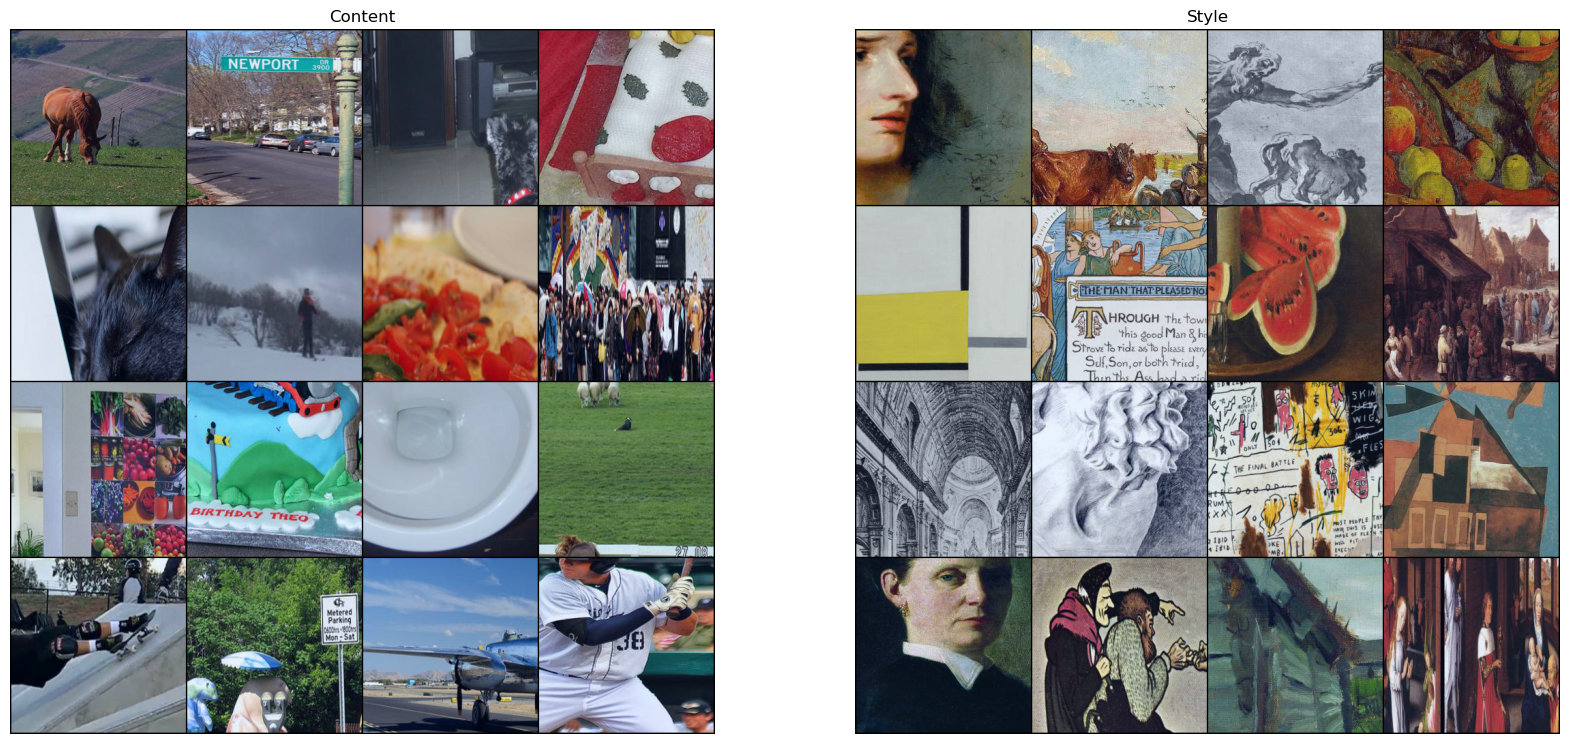

In [35]:
content_images, style_images = next(iter(train_loader))
grid_content = make_grid(content_images, nrow=4, padding=2, normalize=True)
grid_style = make_grid(style_images, nrow=4, padding=2, normalize=True)
plt.figure(figsize=(20, 12))
plt.subplot(1, 2, 1)
plt.imshow(grid_content.permute(1, 2, 0))
plt.title('Content')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(grid_style.permute(1, 2, 0))
plt.title('Style')
plt.axis("off")


plt.show()

In [36]:
def plot_loss(loss_list):
    # plot training loss
    plt.plot(range(len(loss_list)), loss_list)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('train loss')
    plt.savefig(f'{loss_dir}/train_loss.png')
    plt.show()

In [37]:
# set model and optimizer
model = Model()
model = model.to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)

In [38]:
def load_last_checkpoint(model, optimizer, model_state_dir):
    """
    Загрузка последнего чекпоинта из директории.
    """
    checkpoint_files = [f for f in os.listdir(model_state_dir) if f.endswith('.pth')]

    if not checkpoint_files:
        print("No checkpoint found. Starting training from scratch.")
        return 1, []  # Начинаем с первой эпохи

    # Сортируем файлы по номеру эпохи
    checkpoint_files.sort(key=lambda x: int(x.split('_')[0]))  
    latest_checkpoint = checkpoint_files[-1]  

    # Путь к последнему чекпоинту
    path = os.path.join(model_state_dir, latest_checkpoint)
    print(f"Loading checkpoint from {path}...")

    # Загружаем данные из чекпоинта
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    start_epoch = checkpoint["epoch"] + 1 
    loss_list = checkpoint.get("loss_list", [])

    print(f"Checkpoint loaded. Resuming from epoch {start_epoch}.")
    return start_epoch, loss_list



In [39]:

def save_checkpoint(model, optimizer, epoch, loss_list, path="checkpoint.pth"):
    """
    Сохранение состояния модели, оптимизатора и текущей эпохи.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'loss_list': loss_list
    }
    torch.save(checkpoint, path)


In [40]:
# Функция для тренировки
def train_model(model, optimizer, train_loader, epochs=10, model_state_dir="model_state", loss_dir="loss"):
   
     # Загрузка чекпоинта
    start_epoch, loss_list = load_last_checkpoint(model, optimizer, model_state_dir)

    for epoch in range(start_epoch, epochs + 1):
        print(f'Starting epoch {epoch}/{epochs}')
        epoch_loss = 0.0

        for i, (content, style) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}"):
            content = content.to(device)
            style = style.to(device)

            loss = model(content, style)
            epoch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f'Epoch {epoch} completed. Average Loss: {avg_epoch_loss:.4f}')
        loss_list.append(avg_epoch_loss)

        # Сохранение чекпоинта
        save_checkpoint(model, optimizer, epoch, loss_list, path=f"{model_state_dir}/{epoch}_epoch.pth")

    # Сохраняем потери в файл
    with open(f"{loss_dir}/loss_log.txt", 'w') as f:
        for l in loss_list:
            f.write(f'{l}\n')

    print(f"Training completed. Loss log saved to {loss_dir}.")
    return loss_list



In [41]:
loss_list = train_model(model, optimizer, train_loader, epochs=epochs)

Loading checkpoint from model_state\20_epoch.pth...


C:\Users\qwe\AppData\Local\Temp\ipykernel_16972\686160612.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint loaded. Resuming from epoch 21.
Training completed. Loss log saved to loss.


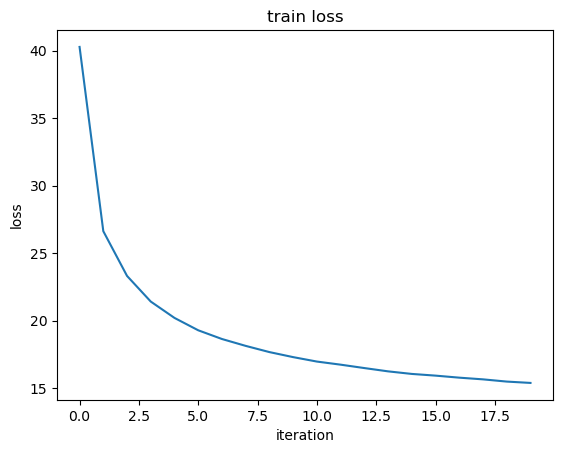

In [42]:
plot_loss(loss_list)

In [43]:
# test
model.eval()

# Возмем 5 изображений для теста
num_test_range = (train_size + 1, train_size + 6)

test_transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])])

test_dataset = ContentStyleDataset(test_content_dir, test_style_dir, transform=test_transform, num_range=num_test_range)
iters = len(test_dataset)
print(f'Length of test image pairs: {iters}')

test_loader = DataLoader(test_dataset, batch_size=iters, shuffle=False)


Length of test image pairs: 5


0it [00:00, ?it/s]

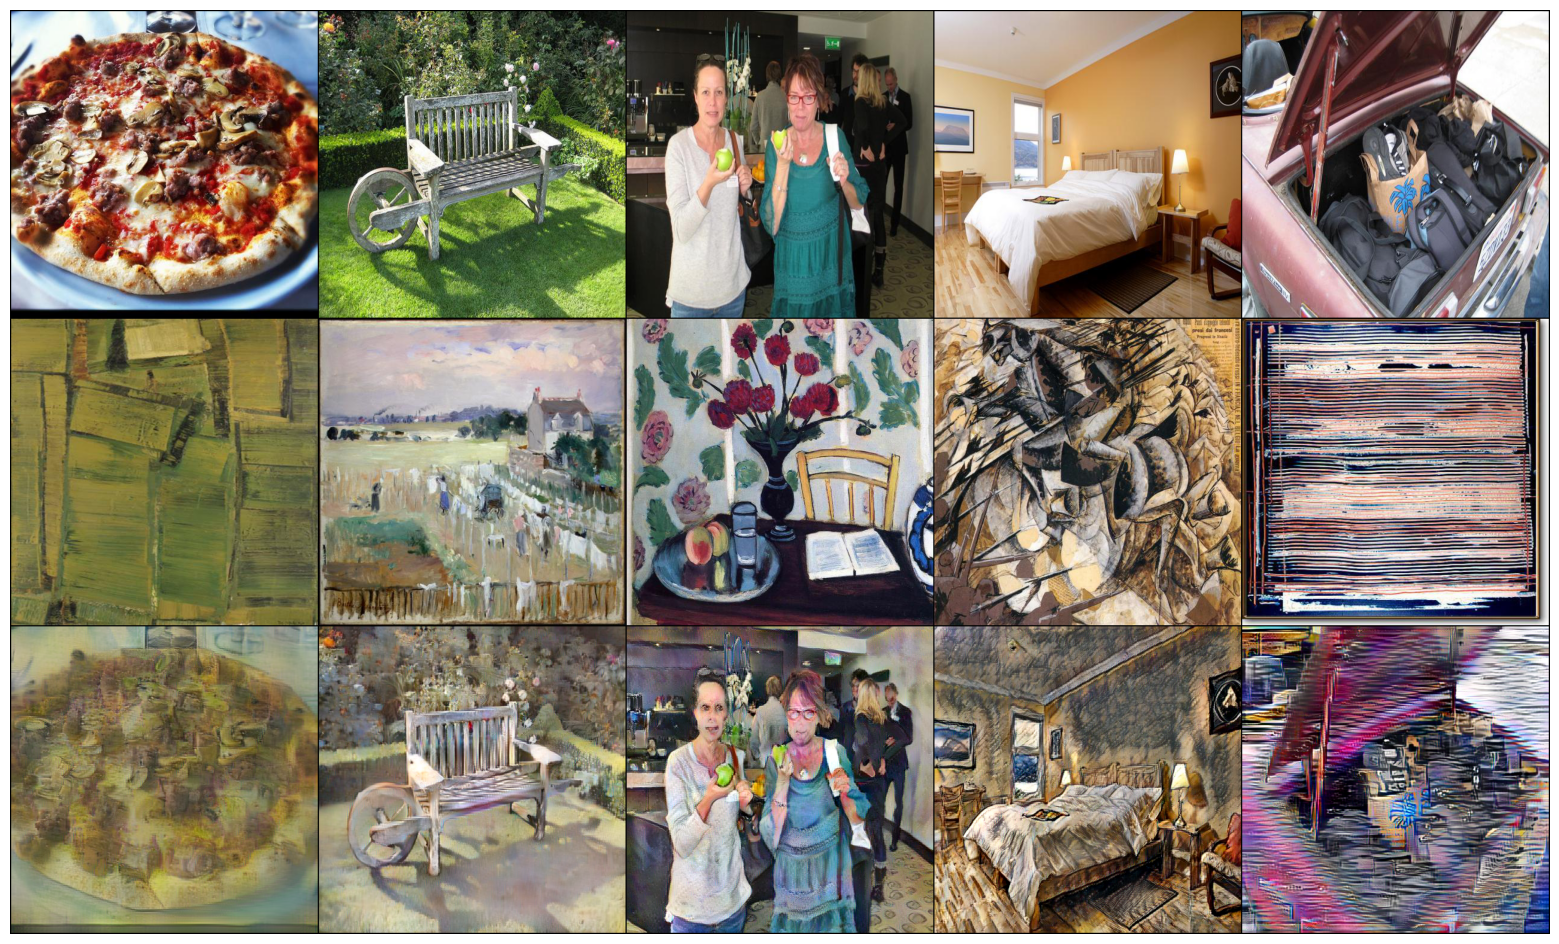

In [44]:

for i, (content, style) in tqdm(enumerate(test_loader, 1)):
    content = content.to(device)
    style = style.to(device)
    with torch.no_grad():
        out = model.generate(content, style)
        content = denorm(content, device).detach().cpu()
        style = denorm(style, device).detach().cpu()
        out = denorm(out, device).detach().cpu() 
        res = torch.cat([content, style, out], dim=0)
        grid_img = make_grid(res, nrow=iters)
        plt.figure(figsize=(20, 12))
        plt.imshow(grid_img.permute(1, 2, 0))
        plt.axis("off")

In [45]:
torch.save(model,  'model.pth')